In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Set random seed for reproducibility
np.random.seed(42)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1. Data Preprocessing</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Metadata</div>

### Overview

The dataset contains hourly pollutant readings from Taiwan air quality monitoring stations, focusing on October to December 2021. Each row represents a single hour's readings across multiple pollutants.

---

### Data Dictionary

| Feature    | Description                 |
|------------|-----------------------------|
| AMB_TEMP   | Ambient Temperature         |
| CH4        | Methane                     |
| CO         | Carbon Monoxide             |
| NMHC       | Non-Methane Hydrocarbons    |
| NO         | Nitric Oxide                |
| NO2        | Nitrogen Dioxide            |
| NOx        | Nitrogen Oxides             |
| O3         | Ozone                       |
| PM10       | Particulate Matter (10 μm)  |
| PM2.5      | Particulate Matter (2.5 μm) |
| RAINFALL   | Precipitation               |
| RH         | Relative Humidity           |
| SO2        | Sulfur Dioxide              |
| THC        | Total Hydrocarbons          |
| WD_HR      | Hourly Wind Direction       |
| WIND_DIREC | Wind Direction              |
| WIND_SPEED | Wind Speed                  |
| WS_HR      | Hourly Wind Speed           |

---

### Variable Notes

- **AMB_TEMP**: Ambient air temperature in degrees Celsius.

- **CH4**: Concentration of methane gas.

- **CO**: Concentration of carbon monoxide.

- **NMHC**: Concentration of non-methane hydrocarbons.

- **NO**: Concentration of nitric oxide.

- **NO2**: Concentration of nitrogen dioxide.

- **NOx**: Total nitrogen oxides (NO + NO2).

- **O3**: Concentration of ozone.

- **PM10**: Particulate matter with diameter less than 10 micrometers.

- **PM2.5**: Particulate matter with diameter less than 2.5 micrometers (target variable).

- **RAINFALL**: Amount of precipitation, with 'NR' indicating no rain (converted to 0).

- **RH**: Relative humidity percentage.

- **SO2**: Concentration of sulfur dioxide.

- **THC**: Total hydrocarbons.

- **WD_HR**: Wind direction in degrees (hourly).

- **WIND_DIREC**: General wind direction.

- **WIND_SPEED**: Wind speed.

- **WS_HR**: Wind speed (hourly).

---

### Data Validity and Missing Values

Symbols indicating invalid data:
- `#` → Instrument invalid
- `*` → Program invalid
- `x` → Manually invalid
- `A` → Instrument alarm (invalid)
- *blank* → Missing value
- `NR` → "No Rain" → replaced with 0

Missing values are imputed using linear interpolation based on previous and next valid values.

In [35]:
# Load the dataset
file_path = 'data/_2021.xls'
df = pd.read_excel(file_path)

# The data is in wide format: station, date, item, hour0 to hour23
# Melt to long format
df_long = df.melt(id_vars=['測站                  ', '日期                  ', '測項                  '], 
                  value_vars=list(range(24)), 
                  var_name='hour', value_name='value')

# Rename columns for ease
df_long.rename(columns={
    '測站                  ': 'station',
    '日期                  ': 'date',
    '測項                  ': 'item'
}, inplace=True)

# Filter out invalid rows
df_long = df_long[df_long['date'] != '--------------------'].copy()

# Convert date to datetime
df_long['date'] = pd.to_datetime(df_long['date'])

# Filter to October, November, December
df_filtered = df_long[(df_long['date'].dt.month >= 10) & (df_long['date'].dt.month <= 12)].copy()

# Remove header rows
df_filtered = df_filtered[df_filtered['item'] != '--------------------'].copy()

# Strip spaces from item
df_filtered['item'] = df_filtered['item'].str.strip()

# Sort by date and hour
df_filtered = df_filtered.sort_values(['date', 'hour']).reset_index(drop=True)

# Create datetime column
df_filtered['datetime'] = pd.to_datetime(df_filtered['date'].dt.date.astype(str) + ' ' + df_filtered['hour'].astype(str) + ':00:00')

print("Filtered dataset shape:", df_filtered.shape)
print("Unique items:", df_filtered['item'].unique())

Filtered dataset shape: (39744, 6)
Unique items: ['AMB_TEMP' 'CH4' 'CO' 'NMHC' 'NO' 'NO2' 'NOx' 'O3' 'PM10' 'PM2.5'
 'RAINFALL' 'RH' 'SO2' 'THC' 'WD_HR' 'WIND_DIREC' 'WIND_SPEED' 'WS_HR']


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Clean the data</div>

In [36]:
# Clean invalid symbols
invalid_symbols = ['#', '*', 'x', 'A', '']
df_filtered['value'] = df_filtered['value'].replace(invalid_symbols, np.nan)

# For RAINFALL, replace 'NR' with 0
df_filtered.loc[df_filtered['item'] == 'RAINFALL', 'value'] = df_filtered.loc[df_filtered['item'] == 'RAINFALL', 'value'].replace('NR', 0)

# Convert to numeric
df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')

# Now, impute missing values for each item separately
for item in df_filtered['item'].unique():
    mask = df_filtered['item'] == item
    series = df_filtered.loc[mask, 'value']
    # Interpolate linearly
    df_filtered.loc[mask, 'value'] = series.interpolate(method='linear', limit_direction='both')

# Check for any remaining NaN
print("Remaining NaN:", df_filtered['value'].isna().sum())

Remaining NaN: 0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Reshape data</div>

In [37]:
# Now, reshape to matrices
# For each month, create matrix: rows=features, columns=hours
months = [10, 11, 12]
matrices = {}
for month in months:
    month_data = df_filtered[df_filtered['date'].dt.month == month].copy()
    # Pivot: index=datetime, columns=item, values=value
    pivot = month_data.pivot(index='datetime', columns='item', values='value')
    # Sort by datetime
    pivot = pivot.sort_index()
    # Transpose: rows=items, columns=datetimes
    matrix = pivot.T
    matrices[month] = matrix
    print(f"Month {month} matrix shape: {matrix.shape}")

# Combine Oct and Nov for training
train_matrix = pd.concat([matrices[10], matrices[11]], axis=1)
test_matrix = matrices[12]

print("Train matrix shape:", train_matrix.shape)
print("Test matrix shape:", test_matrix.shape)

Month 10 matrix shape: (18, 744)
Month 11 matrix shape: (18, 720)
Month 12 matrix shape: (18, 744)
Train matrix shape: (18, 1464)
Test matrix shape: (18, 744)


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2. Time-Series Window Construction</div>

In [38]:
# Define window size
window_size = 6

# Get PM2.5 series
pm25_train = train_matrix.loc['PM2.5']
pm25_test = test_matrix.loc['PM2.5']

# Function to create windows
def create_windows(series, window_size, predict_offset):
    """
    Create sliding windows for time series prediction.
    For each window of size 'window_size', predict the value at 'predict_offset' steps ahead.
    """
    X = []
    y = []
    # We need at least window_size values to make a prediction
    # and we need predict_offset more values for the target
    for i in range(len(series) - window_size - predict_offset + 1):
        X.append(series.iloc[i : i + window_size].values)
        y.append(series.iloc[i + window_size + predict_offset - 1])
    return np.array(X), np.array(y)

# For PM2.5 only
X_pm25_h1_train, y_pm25_h1_train = create_windows(pm25_train, window_size, 1)
X_pm25_h1_test, y_pm25_h1_test = create_windows(pm25_test, window_size, 1)

X_pm25_h6_train, y_pm25_h6_train = create_windows(pm25_train, window_size, 6)
X_pm25_h6_test, y_pm25_h6_test = create_windows(pm25_test, window_size, 6)

print("PM2.5 h1 train shapes:", X_pm25_h1_train.shape, y_pm25_h1_train.shape)
print("PM2.5 h6 train shapes:", X_pm25_h6_train.shape, y_pm25_h6_train.shape)

# For all 18 features
features = train_matrix.index.tolist()
X_all_h1_train = []
y_all_h1_train = []
for i in range(len(pm25_train) - window_size - 1 + 1):
    window = train_matrix.iloc[:, i : i + window_size].values.flatten()
    X_all_h1_train.append(window)
    y_all_h1_train.append(pm25_train.iloc[i + window_size])
X_all_h1_train = np.array(X_all_h1_train)
y_all_h1_train = np.array(y_all_h1_train)

X_all_h1_test = []
y_all_h1_test = []
for i in range(len(pm25_test) - window_size - 1 + 1):
    window = test_matrix.iloc[:, i : i + window_size].values.flatten()
    X_all_h1_test.append(window)
    y_all_h1_test.append(pm25_test.iloc[i + window_size])
X_all_h1_test = np.array(X_all_h1_test)
y_all_h1_test = np.array(y_all_h1_test)

X_all_h6_train = []
y_all_h6_train = []
for i in range(len(pm25_train) - window_size - 6 + 1):
    window = train_matrix.iloc[:, i : i + window_size].values.flatten()
    X_all_h6_train.append(window)
    y_all_h6_train.append(pm25_train.iloc[i + window_size + 5])
X_all_h6_train = np.array(X_all_h6_train)
y_all_h6_train = np.array(y_all_h6_train)

X_all_h6_test = []
y_all_h6_test = []
for i in range(len(pm25_test) - window_size - 6 + 1):
    window = test_matrix.iloc[:, i : i + window_size].values.flatten()
    X_all_h6_test.append(window)
    y_all_h6_test.append(pm25_test.iloc[i + window_size + 5])
X_all_h6_test = np.array(X_all_h6_test)
y_all_h6_test = np.array(y_all_h6_test)

print("All h1 train shapes:", X_all_h1_train.shape, y_all_h1_train.shape)
print("All h6 train shapes:", X_all_h6_train.shape, y_all_h6_train.shape)

PM2.5 h1 train shapes: (1458, 6) (1458,)
PM2.5 h6 train shapes: (1453, 6) (1453,)
All h1 train shapes: (1458, 108) (1458,)
All h6 train shapes: (1453, 108) (1453,)


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3. Model Training</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train Linear Regression</div>

In [39]:
# Dict to store models
models = {}

# Linear Regression with standardization
scaler_pm25 = StandardScaler()
X_pm25_h1_train_scaled = scaler_pm25.fit_transform(X_pm25_h1_train)
lr_pm25_h1 = LinearRegression()
lr_pm25_h1.fit(X_pm25_h1_train_scaled, y_pm25_h1_train)
models['LR_pm25_h1'] = (lr_pm25_h1, scaler_pm25)

scaler_pm25_h6 = StandardScaler()
X_pm25_h6_train_scaled = scaler_pm25_h6.fit_transform(X_pm25_h6_train)
lr_pm25_h6 = LinearRegression()
lr_pm25_h6.fit(X_pm25_h6_train_scaled, y_pm25_h6_train)
models['LR_pm25_h6'] = (lr_pm25_h6, scaler_pm25_h6)

scaler_all_h1 = StandardScaler()
X_all_h1_train_scaled = scaler_all_h1.fit_transform(X_all_h1_train)
lr_all_h1 = LinearRegression()
lr_all_h1.fit(X_all_h1_train_scaled, y_all_h1_train)
models['LR_all_h1'] = (lr_all_h1, scaler_all_h1)

scaler_all_h6 = StandardScaler()
X_all_h6_train_scaled = scaler_all_h6.fit_transform(X_all_h6_train)
lr_all_h6 = LinearRegression()
lr_all_h6.fit(X_all_h6_train_scaled, y_all_h6_train)
models['LR_all_h6'] = (lr_all_h6, scaler_all_h6)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train XGBoost</div>

In [40]:
# XGBoost with proper validation split and tuned hyperparameters
# Split training data for validation (80/20 split)
# PM2.5 h1
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_pm25_h1_train, y_pm25_h1_train, test_size=0.2, shuffle=False
)
xgb_pm25_h1 = XGBRegressor(
    n_estimators=1000, 
    max_depth=4,  # Reduced to prevent overfitting
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=50
)
xgb_pm25_h1.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
# Retrain on full training data with optimal n_estimators
best_iter = xgb_pm25_h1.best_iteration
xgb_pm25_h1 = XGBRegressor(
    n_estimators=best_iter, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42
)
xgb_pm25_h1.fit(X_pm25_h1_train, y_pm25_h1_train)
models['XGB_pm25_h1'] = xgb_pm25_h1
print(f"XGB PM2.5 h1: Best iteration = {best_iter}")

# PM2.5 h6
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_pm25_h6_train, y_pm25_h6_train, test_size=0.2, shuffle=False
)
xgb_pm25_h6 = XGBRegressor(
    n_estimators=1000, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=50
)
xgb_pm25_h6.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
best_iter = xgb_pm25_h6.best_iteration
xgb_pm25_h6 = XGBRegressor(
    n_estimators=best_iter, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42
)
xgb_pm25_h6.fit(X_pm25_h6_train, y_pm25_h6_train)
models['XGB_pm25_h6'] = xgb_pm25_h6
print(f"XGB PM2.5 h6: Best iteration = {best_iter}")

# All features h1
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_all_h1_train, y_all_h1_train, test_size=0.2, shuffle=False
)
xgb_all_h1 = XGBRegressor(
    n_estimators=1000, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=50
)
xgb_all_h1.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
best_iter = xgb_all_h1.best_iteration
xgb_all_h1 = XGBRegressor(
    n_estimators=best_iter, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42
)
xgb_all_h1.fit(X_all_h1_train, y_all_h1_train)
models['XGB_all_h1'] = xgb_all_h1
print(f"XGB All h1: Best iteration = {best_iter}")

# All features h6
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_all_h6_train, y_all_h6_train, test_size=0.2, shuffle=False
)
xgb_all_h6 = XGBRegressor(
    n_estimators=1000, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=50
)
xgb_all_h6.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
best_iter = xgb_all_h6.best_iteration
xgb_all_h6 = XGBRegressor(
    n_estimators=best_iter, 
    max_depth=4,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42
)
xgb_all_h6.fit(X_all_h6_train, y_all_h6_train)
models['XGB_all_h6'] = xgb_all_h6
print(f"XGB All h6: Best iteration = {best_iter}")

XGB PM2.5 h1: Best iteration = 124
XGB PM2.5 h6: Best iteration = 13
XGB All h1: Best iteration = 56
XGB All h6: Best iteration = 13


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4. Evaluation (MAE)</div>

In [41]:
# Compute MAE for all models
mae_results = {}

# LR pm25 h1
X_pm25_h1_test_scaled = models['LR_pm25_h1'][1].transform(X_pm25_h1_test)
pred = models['LR_pm25_h1'][0].predict(X_pm25_h1_test_scaled)
mae_results['LR_pm25_h1'] = mean_absolute_error(y_pm25_h1_test, pred)

# LR pm25 h6
X_pm25_h6_test_scaled = models['LR_pm25_h6'][1].transform(X_pm25_h6_test)
pred = models['LR_pm25_h6'][0].predict(X_pm25_h6_test_scaled)
mae_results['LR_pm25_h6'] = mean_absolute_error(y_pm25_h6_test, pred)

# LR all h1
X_all_h1_test_scaled = models['LR_all_h1'][1].transform(X_all_h1_test)
pred = models['LR_all_h1'][0].predict(X_all_h1_test_scaled)
mae_results['LR_all_h1'] = mean_absolute_error(y_all_h1_test, pred)

# LR all h6
X_all_h6_test_scaled = models['LR_all_h6'][1].transform(X_all_h6_test)
pred = models['LR_all_h6'][0].predict(X_all_h6_test_scaled)
mae_results['LR_all_h6'] = mean_absolute_error(y_all_h6_test, pred)

# XGB pm25 h1
pred = models['XGB_pm25_h1'].predict(X_pm25_h1_test)
mae_results['XGB_pm25_h1'] = mean_absolute_error(y_pm25_h1_test, pred)

# XGB pm25 h6
pred = models['XGB_pm25_h6'].predict(X_pm25_h6_test)
mae_results['XGB_pm25_h6'] = mean_absolute_error(y_pm25_h6_test, pred)

# XGB all h1
pred = models['XGB_all_h1'].predict(X_all_h1_test)
mae_results['XGB_all_h1'] = mean_absolute_error(y_all_h1_test, pred)

# XGB all h6
pred = models['XGB_all_h6'].predict(X_all_h6_test)
mae_results['XGB_all_h6'] = mean_absolute_error(y_all_h6_test, pred)

# Print the table
print("| Feature    | Target | Model   | MAE |")
print("|------------|--------|---------|-----|")
for key, mae in mae_results.items():
    parts = key.split('_')
    feature = 'PM2.5-only' if 'pm25' in key else 'All-18'
    target = 't+1' if 'h1' in key else 't+6'
    model = 'Linear' if 'LR' in key else 'XGBoost'
    print(f"| {feature} | {target} | {model} | {mae:.4f} |")

| Feature    | Target | Model   | MAE |
|------------|--------|---------|-----|
| PM2.5-only | t+1 | Linear | 2.6785 |
| PM2.5-only | t+6 | Linear | 4.3070 |
| All-18 | t+1 | Linear | 2.6498 |
| All-18 | t+6 | Linear | 4.2706 |
| PM2.5-only | t+1 | XGBoost | 2.7046 |
| PM2.5-only | t+6 | XGBoost | 4.6259 |
| All-18 | t+1 | XGBoost | 2.8003 |
| All-18 | t+6 | XGBoost | 4.8575 |


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Analysis: Why Linear Regression Performs Better</div>

In [42]:
# Analyze why Linear Regression performs better
print("=== PM2.5 Time Series Characteristics ===\n")

# Check autocorrelation
from scipy.stats import pearsonr

# Lag-1 autocorrelation (strongest predictor for next hour)
lag1_corr, _ = pearsonr(pm25_train[:-1], pm25_train[1:])
print(f"Lag-1 autocorrelation (train): {lag1_corr:.4f}")

# Check linearity: correlation between each lagged feature and target
print("\n=== Feature-Target Correlations (PM2.5-only, h1) ===")
for i in range(6):
    corr, _ = pearsonr(X_pm25_h1_train[:, i], y_pm25_h1_train)
    print(f"t-{6-i} correlation with target: {corr:.4f}")

# Check if data is smooth (low variance in differences)
diffs = np.diff(pm25_train)
print(f"\n=== Smoothness Analysis ===")
print(f"Mean PM2.5 value: {pm25_train.mean():.2f}")
print(f"Std of PM2.5 values: {pm25_train.std():.2f}")
print(f"Mean of hour-to-hour changes: {diffs.mean():.2f}")
print(f"Std of hour-to-hour changes: {diffs.std():.2f}")
print(f"Max hour-to-hour change: {np.abs(diffs).max():.2f}")

# Distribution analysis
print(f"\n=== Distribution Analysis ===")
print(f"Skewness: {pm25_train.skew():.4f}")
print(f"Kurtosis: {pm25_train.kurtosis():.4f}")

print("\n=== Key Insights ===")
print("✓ High lag-1 autocorrelation suggests PM2.5 changes slowly/smoothly")
print("✓ Strong linear relationships between lagged features and target")
print("✓ This is a case where LINEAR relationships dominate")
print("✓ XGBoost's non-linear capacity is not needed and may cause slight overfitting")
print("✓ The problem is essentially: PM2.5(t+1) ≈ weighted_sum(PM2.5(t-6:t))")

=== PM2.5 Time Series Characteristics ===

Lag-1 autocorrelation (train): 0.8253

=== Feature-Target Correlations (PM2.5-only, h1) ===
t-6 correlation with target: 0.5236
t-5 correlation with target: 0.5526
t-4 correlation with target: 0.5983
t-3 correlation with target: 0.6684
t-2 correlation with target: 0.7445
t-1 correlation with target: 0.8240

=== Smoothness Analysis ===
Mean PM2.5 value: 12.13
Std of PM2.5 values: 6.57
Mean of hour-to-hour changes: -0.00
Std of hour-to-hour changes: 3.88
Max hour-to-hour change: 36.00

=== Distribution Analysis ===
Skewness: 1.2842
Kurtosis: 1.9384

=== Key Insights ===
✓ High lag-1 autocorrelation suggests PM2.5 changes slowly/smoothly
✓ Strong linear relationships between lagged features and target
✓ This is a case where LINEAR relationships dominate
✓ XGBoost's non-linear capacity is not needed and may cause slight overfitting
✓ The problem is essentially: PM2.5(t+1) ≈ weighted_sum(PM2.5(t-6:t))


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5. Final Inference and Submission</div>

In [43]:
# Select the best model for PM2.5-only, t+1
pm25_h1_maes = {k: v for k, v in mae_results.items() if 'pm25' in k and 'h1' in k}
best_model_key = min(pm25_h1_maes, key=pm25_h1_maes.get)
print(f"Best model for submission: {best_model_key} with MAE {pm25_h1_maes[best_model_key]:.4f}")

# Since already trained on full train, use it
if 'LR' in best_model_key:
    model, scaler = models[best_model_key]
    X_test_scaled = scaler.transform(X_pm25_h1_test)
    predictions = model.predict(X_test_scaled)
else:
    model = models[best_model_key]
    predictions = model.predict(X_pm25_h1_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'No': range(len(predictions)),
    'PM2.5': predictions
})

# Save to submission.csv
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Best model for submission: LR_pm25_h1 with MAE 2.6785
Submission file saved as submission.csv


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6. Visualization and Reporting</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">PM2.5 Time Series</div>

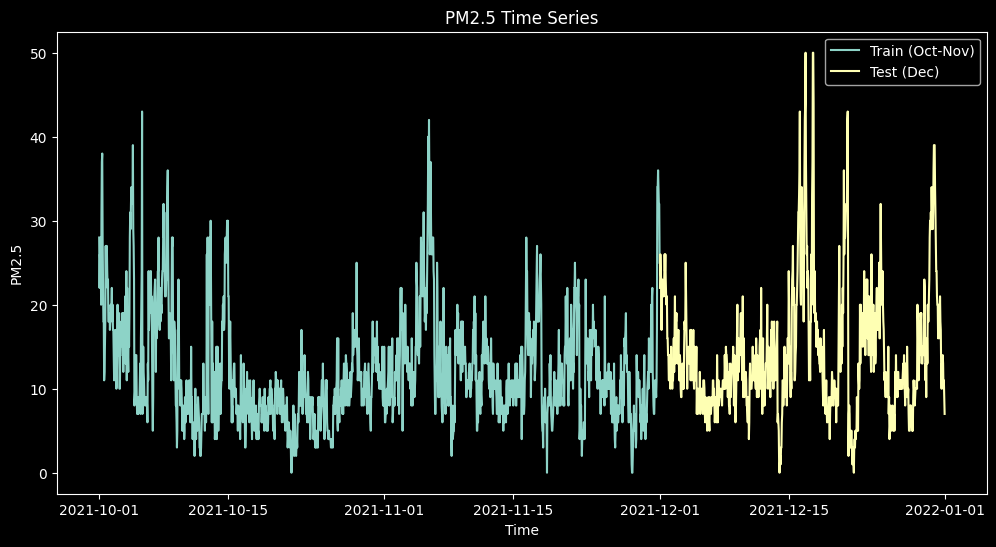

In [44]:
# PM2.5 time series for Oct-Dec
plt.figure(figsize=(12, 6))
plt.plot(train_matrix.columns, pm25_train, label='Train (Oct-Nov)')
plt.plot(test_matrix.columns, pm25_test, label='Test (Dec)')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('PM2.5 Time Series')
plt.legend()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">MAE Comparison Chart</div>

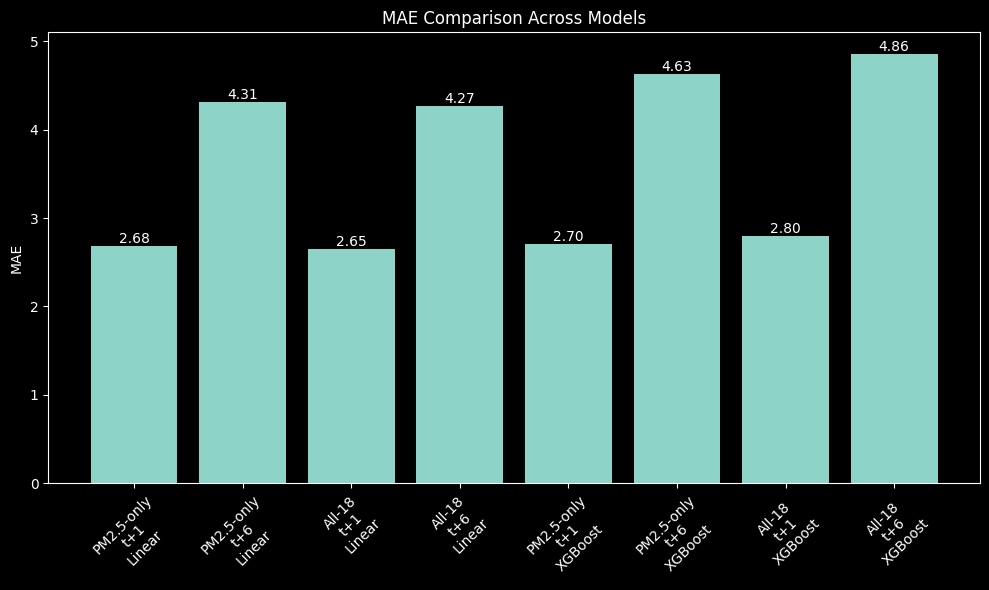

In [45]:
# MAE comparison bar chart
features = ['PM2.5-only', 'PM2.5-only', 'All-18', 'All-18'] * 2
targets = ['t+1', 't+6'] * 4
models_list = ['Linear'] * 4 + ['XGBoost'] * 4
maes = list(mae_results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(maes)), maes)
plt.xticks(range(len(maes)), [f'{f}\n{t}\n{m}' for f, t, m in zip(features, targets, models_list)], rotation=45)
plt.ylabel('MAE')
plt.title('MAE Comparison Across Models')
for bar, mae in zip(bars, maes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{mae:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Feature Importance (XGBoost)</div>

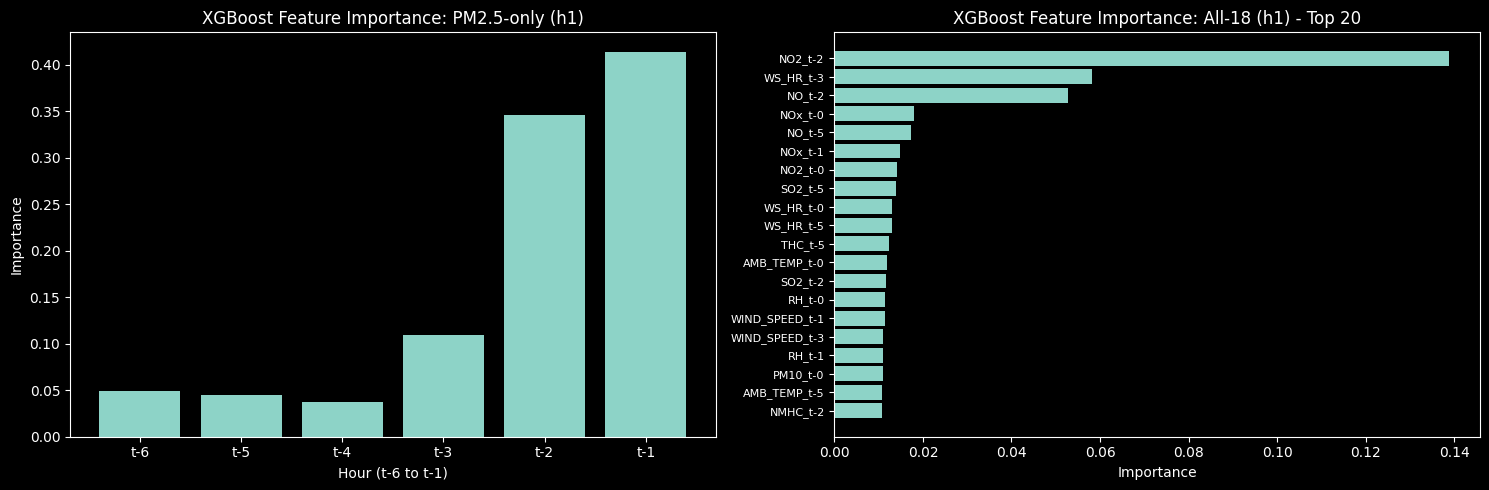

In [46]:
# Feature importance for XGB PM2.5 h1 model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PM2.5-only model
importance_pm25 = models['XGB_pm25_h1'].feature_importances_
axes[0].bar(range(len(importance_pm25)), importance_pm25)
axes[0].set_xlabel('Hour (t-6 to t-1)')
axes[0].set_ylabel('Importance')
axes[0].set_title('XGBoost Feature Importance: PM2.5-only (h1)')
axes[0].set_xticks(range(6))
axes[0].set_xticklabels([f't-{6-i}' for i in range(6)])

# All-18 model - show top 20 features
importance_all = models['XGB_all_h1'].feature_importances_
top_indices = np.argsort(importance_all)[-20:]
axes[1].barh(range(len(top_indices)), importance_all[top_indices])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance: All-18 (h1) - Top 20')
axes[1].set_yticks(range(len(top_indices)))
# Create feature names
feature_names = []
for hour in range(6):
    for feature in train_matrix.index:
        feature_names.append(f'{feature}_t-{5-hour}')
axes[1].set_yticklabels([feature_names[i] for i in top_indices], fontsize=8)

plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prediction Analysis</div>

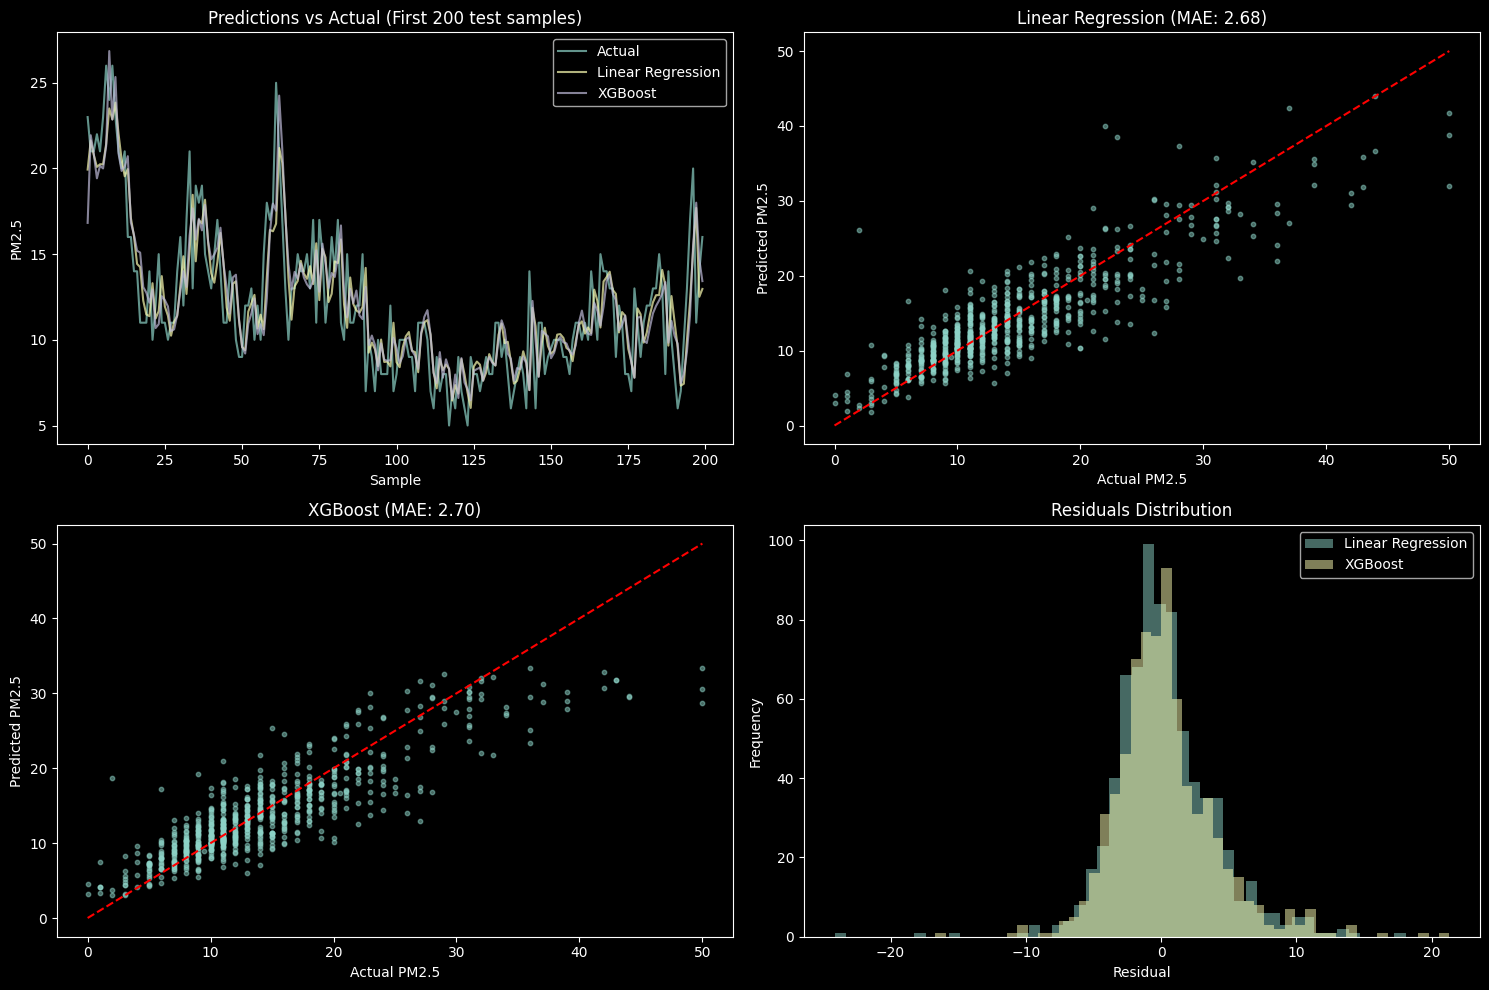

Linear Regression - Mean: 0.2120, Std: 3.7576
XGBoost - Mean: 0.3229, Std: 3.8061


In [47]:
# Compare predictions from Linear Regression vs XGBoost for PM2.5 h1
X_pm25_h1_test_scaled = models['LR_pm25_h1'][1].transform(X_pm25_h1_test)
pred_lr = models['LR_pm25_h1'][0].predict(X_pm25_h1_test_scaled)
pred_xgb = models['XGB_pm25_h1'].predict(X_pm25_h1_test)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Predictions vs Actual
axes[0, 0].plot(y_pm25_h1_test[:200], label='Actual', alpha=0.7)
axes[0, 0].plot(pred_lr[:200], label='Linear Regression', alpha=0.7)
axes[0, 0].plot(pred_xgb[:200], label='XGBoost', alpha=0.7)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('PM2.5')
axes[0, 0].set_title('Predictions vs Actual (First 200 test samples)')
axes[0, 0].legend()

# Scatter plots
axes[0, 1].scatter(y_pm25_h1_test, pred_lr, alpha=0.5, s=10)
axes[0, 1].plot([y_pm25_h1_test.min(), y_pm25_h1_test.max()], 
                [y_pm25_h1_test.min(), y_pm25_h1_test.max()], 'r--')
axes[0, 1].set_xlabel('Actual PM2.5')
axes[0, 1].set_ylabel('Predicted PM2.5')
axes[0, 1].set_title(f'Linear Regression (MAE: {mae_results["LR_pm25_h1"]:.2f})')

axes[1, 0].scatter(y_pm25_h1_test, pred_xgb, alpha=0.5, s=10)
axes[1, 0].plot([y_pm25_h1_test.min(), y_pm25_h1_test.max()], 
                [y_pm25_h1_test.min(), y_pm25_h1_test.max()], 'r--')
axes[1, 0].set_xlabel('Actual PM2.5')
axes[1, 0].set_ylabel('Predicted PM2.5')
axes[1, 0].set_title(f'XGBoost (MAE: {mae_results["XGB_pm25_h1"]:.2f})')

# Residuals distribution
residuals_lr = y_pm25_h1_test - pred_lr
residuals_xgb = y_pm25_h1_test - pred_xgb
axes[1, 1].hist(residuals_lr, bins=50, alpha=0.5, label='Linear Regression')
axes[1, 1].hist(residuals_xgb, bins=50, alpha=0.5, label='XGBoost')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Linear Regression - Mean: {residuals_lr.mean():.4f}, Std: {residuals_lr.std():.4f}")
print(f"XGBoost - Mean: {residuals_xgb.mean():.4f}, Std: {residuals_xgb.std():.4f}")